In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-03-02 22:15:01.321452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 22:15:01.321636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 22:15:01.429074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab  

In [5]:
vocab=np.unique(get_vocab())

In [6]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [8]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [9]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [10]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

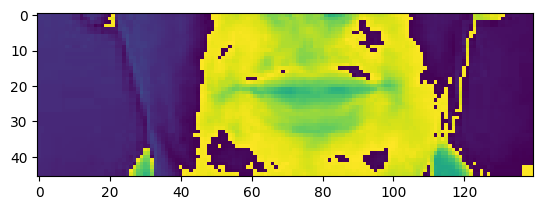

In [11]:
plt.imshow(frames[40])

In [12]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [13]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Division des données en ensembles d'entraînement et de test
train_size = 450
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Création des lots (batches) de données
train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# Préchargement des données
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [14]:
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500,reshuffle_each_iteration=False)
# data = data.map(mappable_function)
# data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)
# # # ADDED DOR SPLIT
# train = data.take(450)
# test = data.skip(450)

In [15]:
# frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[1.4628371 ],
         [1.3858457 ],
         [1.4243413 ],
         ...,
         [0.3079657 ],
         [0.34646142],
         [0.34646142]],

        [[1.3858457 ],
         [1.4628371 ],
         [1.3473499 ],
         ...,
         [0.3079657 ],
         [0.34646142],
         [0.34646142]],

        [[1.5783242 ],
         [1.5783242 ],
         [1.5398285 ],
         ...,
         [0.34646142],
         [0.3079657 ],
         [0.3079657 ]],

        ...,

        [[1.0778799 ],
         [1.0778799 ],
         [1.0778799 ],
         ...,
         [0.03849571],
         [0.03849571],
         [0.03849571]],

        [[1.0393842 ],
         [1.0393842 ],
         [1.0393842 ],
         ...,
         [0.03849571],
         [0.03849571],
         [0.03849571]],

        [[1.0393842 ],
         [1.0393842 ],
         [1.0393842 ],
         ...,
         [0.03849571],
         [0.03849571],
         [0.        ]]],


       [[[1.5013328 ],
         [1.4628371 ],
         [1.42

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [20]:
# class ProduceExample(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

In [21]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, BatchNormalization

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [23]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)


In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [25]:
history=model.fit(train_data,validation_data=test_data,epochs=90,callbacks=[checkpoint_callback,schedule_callback])

Epoch 1/90


I0000 00:00:1709417733.868163      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/225 [=========================>....] - ETA: 20s - loss: 168.1185

[mpeg1video @ 0x7e12781e3300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12781e3300] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 162.3196

[mpeg1video @ 0x7e16a4001780] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a4001780] Warning MVs not available


225/225 [==============================] - 432s 2s/step - loss: 162.3196 - val_loss: 122.7576 - lr: 1.0000e-04
Epoch 2/90
 92/225 [===========>..................] - ETA: 1:35 - loss: 118.4369

[mpeg1video @ 0x7e17d4070b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d4070b00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 110.8193

[mpeg1video @ 0x7e1270075c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1270075c40] Warning MVs not available


225/225 [==============================] - 408s 2s/step - loss: 110.8193 - val_loss: 97.7105 - lr: 1.0000e-04
Epoch 3/90
225/225 [==============================] - ETA: 0s - loss: 99.7114

[mpeg1video @ 0x7e16f4076d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16f4076d40] Warning MVs not available


225/225 [==============================] - 404s 2s/step - loss: 99.7114 - val_loss: 94.7193 - lr: 1.0000e-04
Epoch 4/90
225/225 [==============================] - ETA: 0s - loss: 95.6346

[mpeg1video @ 0x7e1278002740] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1278002740] Warning MVs not available


225/225 [==============================] - 402s 2s/step - loss: 95.6346 - val_loss: 99.6531 - lr: 1.0000e-04
Epoch 5/90
207/225 [==========================>...] - ETA: 12s - loss: 91.8013

[mpeg1video @ 0x7e11ec6b1080] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec6b1080] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 92.1582

[mpeg1video @ 0x7e17080dde40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17080dde40] Warning MVs not available


225/225 [==============================] - 401s 2s/step - loss: 92.1582 - val_loss: 82.0434 - lr: 1.0000e-04
Epoch 6/90
 98/225 [============>.................] - ETA: 1:28 - loss: 92.1217

[mpeg1video @ 0x7e17d4005940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d4005940] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 89.4161

[mpeg1video @ 0x7e1274040b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1274040b80] Warning MVs not available


225/225 [==============================] - 400s 2s/step - loss: 89.4161 - val_loss: 79.8107 - lr: 1.0000e-04
Epoch 7/90
216/225 [===========================>..] - ETA: 6s - loss: 86.3618

[mpeg1video @ 0x7e11ec914bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec914bc0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 86.1726

[mpeg1video @ 0x7e16b807e100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b807e100] Warning MVs not available


225/225 [==============================] - 402s 2s/step - loss: 86.1726 - val_loss: 78.7816 - lr: 1.0000e-04
Epoch 8/90
225/225 [==============================] - ETA: 0s - loss: 85.3295

[mpeg1video @ 0x7e1278021dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1278021dc0] Warning MVs not available


225/225 [==============================] - 400s 2s/step - loss: 85.3295 - val_loss: 78.2214 - lr: 1.0000e-04
Epoch 9/90
154/225 [===================>..........] - ETA: 50s - loss: 84.5098

[mpeg1video @ 0x7e1679902600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679902600] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 83.1874

[mpeg1video @ 0x7e16b0056c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b0056c00] Warning MVs not available


225/225 [==============================] - 398s 2s/step - loss: 83.1874 - val_loss: 77.2460 - lr: 1.0000e-04
Epoch 10/90
162/225 [====================>.........] - ETA: 44s - loss: 82.5920

[mpeg1video @ 0x7e17d8023f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d8023f40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 82.1068

[mpeg1video @ 0x7e12700b5a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12700b5a00] Warning MVs not available


225/225 [==============================] - 397s 2s/step - loss: 82.1068 - val_loss: 74.5188 - lr: 1.0000e-04
Epoch 11/90
214/225 [===========================>..] - ETA: 7s - loss: 80.9825

[mpeg1video @ 0x7e16866f5540] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16866f5540] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 80.5856

[mpeg1video @ 0x7e16b80a3200] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b80a3200] Warning MVs not available


225/225 [==============================] - 398s 2s/step - loss: 80.5856 - val_loss: 74.1659 - lr: 1.0000e-04
Epoch 12/90
199/225 [=========================>....] - ETA: 18s - loss: 78.1444

[mpeg1video @ 0x7e17d80296c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d80296c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 77.4892

[mpeg1video @ 0x7e166c00ab00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e166c00ab00] Warning MVs not available


225/225 [==============================] - 399s 2s/step - loss: 77.4892 - val_loss: 67.0237 - lr: 1.0000e-04
Epoch 13/90
205/225 [==========================>...] - ETA: 14s - loss: 70.3357

[mpeg1video @ 0x7e1679b8ea80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679b8ea80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 70.0882

[mpeg1video @ 0x7e16b8097ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b8097ec0] Warning MVs not available


225/225 [==============================] - 399s 2s/step - loss: 70.0882 - val_loss: 62.1149 - lr: 1.0000e-04
Epoch 14/90
119/225 [==============>...............] - ETA: 1:14 - loss: 67.4615

[mpeg1video @ 0x7e17c803b040] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c803b040] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 66.3508

[mpeg1video @ 0x7e166c00a7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e166c00a7c0] Warning MVs not available


225/225 [==============================] - 397s 2s/step - loss: 66.3508 - val_loss: 64.2571 - lr: 1.0000e-04
Epoch 15/90
151/225 [===================>..........] - ETA: 51s - loss: 63.8720

[mpeg1video @ 0x7e167990f040] ac-tex damaged at 22 17
[mpeg1video @ 0x7e167990f040] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 63.3165

[mpeg1video @ 0x7e16b8060640] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b8060640] Warning MVs not available


225/225 [==============================] - 397s 2s/step - loss: 63.3165 - val_loss: 57.2096 - lr: 1.0000e-04
Epoch 16/90
225/225 [==============================] - ETA: 0s - loss: 60.7959

[mpeg1video @ 0x7e127408c5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e127408c5c0] Warning MVs not available


225/225 [==============================] - 398s 2s/step - loss: 60.7959 - val_loss: 57.0761 - lr: 1.0000e-04
Epoch 17/90
102/225 [============>.................] - ETA: 1:26 - loss: 59.9289

[mpeg1video @ 0x7e1686507600] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1686507600] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 58.7119

[mpeg1video @ 0x7e1708104800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1708104800] Warning MVs not available


225/225 [==============================] - 398s 2s/step - loss: 58.7119 - val_loss: 53.3446 - lr: 1.0000e-04
Epoch 18/90
 79/225 [=========>....................] - ETA: 1:41 - loss: 57.8401

[mpeg1video @ 0x7e17d0036c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d0036c80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 57.9242

[mpeg1video @ 0x7e12740570c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12740570c0] Warning MVs not available


225/225 [==============================] - 396s 2s/step - loss: 57.9242 - val_loss: 53.9241 - lr: 1.0000e-04
Epoch 19/90
225/225 [==============================] - ETA: 0s - loss: 55.3816

[mpeg1video @ 0x7e1708062dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1708062dc0] Warning MVs not available


225/225 [==============================] - 400s 2s/step - loss: 55.3816 - val_loss: 48.9518 - lr: 1.0000e-04
Epoch 20/90
225/225 [==============================] - ETA: 0s - loss: 53.0190

[mpeg1video @ 0x7e1278074bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1278074bc0] Warning MVs not available


225/225 [==============================] - 402s 2s/step - loss: 53.0190 - val_loss: 47.2274 - lr: 1.0000e-04
Epoch 21/90
136/225 [=================>............] - ETA: 1:03 - loss: 51.0117

[mpeg1video @ 0x7e16863151c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16863151c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 51.1352

[mpeg1video @ 0x7e17080315c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17080315c0] Warning MVs not available


225/225 [==============================] - 411s 2s/step - loss: 51.1352 - val_loss: 46.3632 - lr: 1.0000e-04
Epoch 22/90
225/225 [==============================] - ETA: 0s - loss: 48.9054

[mpeg1video @ 0x7e1274001800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1274001800] Warning MVs not available


225/225 [==============================] - 405s 2s/step - loss: 48.9054 - val_loss: 42.1424 - lr: 1.0000e-04
Epoch 23/90
158/225 [====================>.........] - ETA: 48s - loss: 45.9011

[mpeg1video @ 0x7e1686203200] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1686203200] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 45.7633

[mpeg1video @ 0x7e17080218c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17080218c0] Warning MVs not available


225/225 [==============================] - 406s 2s/step - loss: 45.7633 - val_loss: 41.3596 - lr: 1.0000e-04
Epoch 24/90
225/225 [==============================] - ETA: 0s - loss: 43.5432

[mpeg1video @ 0x7e1274091940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1274091940] Warning MVs not available


225/225 [==============================] - 402s 2s/step - loss: 43.5432 - val_loss: 39.6686 - lr: 1.0000e-04
Epoch 25/90
225/225 [==============================] - ETA: 0s - loss: 40.8938

[mpeg1video @ 0x7e1708014c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1708014c40] Warning MVs not available


225/225 [==============================] - 400s 2s/step - loss: 40.8938 - val_loss: 35.7290 - lr: 1.0000e-04
Epoch 26/90
 22/225 [=>............................] - ETA: 2:22 - loss: 39.3414

[mpeg1video @ 0x7e17d801ee40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d801ee40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 38.5861

[mpeg1video @ 0x7e1274014ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1274014ac0] Warning MVs not available


225/225 [==============================] - 401s 2s/step - loss: 38.5861 - val_loss: 32.3905 - lr: 1.0000e-04
Epoch 27/90
 16/225 [=>............................] - ETA: 2:27 - loss: 38.1484

[mpeg1video @ 0x7e1686666f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1686666f80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 36.4993

[mpeg1video @ 0x7e16b806ed00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b806ed00] Warning MVs not available


225/225 [==============================] - 400s 2s/step - loss: 36.4993 - val_loss: 29.6987 - lr: 1.0000e-04
Epoch 28/90
 66/225 [=======>......................] - ETA: 1:51 - loss: 34.3060

[mpeg1video @ 0x7e17c8030800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c8030800] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 34.7430

[mpeg1video @ 0x7e127806be00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e127806be00] Warning MVs not available


225/225 [==============================] - 397s 2s/step - loss: 34.7430 - val_loss: 29.7339 - lr: 1.0000e-04
Epoch 29/90
225/225 [==============================] - ETA: 0s - loss: 33.2366

[mpeg1video @ 0x7e16b00af100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b00af100] Warning MVs not available


225/225 [==============================] - 403s 2s/step - loss: 33.2366 - val_loss: 25.5361 - lr: 1.0000e-04
Epoch 30/90
225/225 [==============================] - ETA: 0s - loss: 31.1308

[mpeg1video @ 0x7e12780857c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12780857c0] Warning MVs not available


225/225 [==============================] - 403s 2s/step - loss: 31.1308 - val_loss: 25.1291 - lr: 1.0000e-04
Epoch 31/90
 33/225 [===>..........................] - ETA: 2:17 - loss: 29.2191

[mpeg1video @ 0x7e11ec718880] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec718880] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 28.8386

[mpeg1video @ 0x7e17cc021380] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc021380] Warning MVs not available


225/225 [==============================] - 405s 2s/step - loss: 28.8386 - val_loss: 23.3796 - lr: 9.0484e-05
Epoch 32/90
144/225 [==================>...........] - ETA: 58s - loss: 27.0894

[mpeg1video @ 0x7e17dc0960c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17dc0960c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 27.1153

[mpeg1video @ 0x7e167400d9c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e167400d9c0] Warning MVs not available


225/225 [==============================] - 406s 2s/step - loss: 27.1153 - val_loss: 21.1802 - lr: 8.1873e-05
Epoch 33/90
225/225 [==============================] - ETA: 0s - loss: 26.2139

[mpeg1video @ 0x7e17cc037c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc037c00] Warning MVs not available


225/225 [==============================] - 406s 2s/step - loss: 26.2139 - val_loss: 21.2458 - lr: 7.4082e-05
Epoch 34/90
225/225 [==============================] - ETA: 0s - loss: 23.8347

[mpeg1video @ 0x7e12219adb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12219adb40] Warning MVs not available


225/225 [==============================] - 404s 2s/step - loss: 23.8347 - val_loss: 18.5310 - lr: 6.7032e-05
Epoch 35/90
225/225 [==============================] - ETA: 0s - loss: 22.9167

[mpeg1video @ 0x7e17cc099b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc099b00] Warning MVs not available


225/225 [==============================] - 399s 2s/step - loss: 22.9167 - val_loss: 17.7338 - lr: 6.0653e-05
Epoch 36/90
225/225 [==============================] - ETA: 0s - loss: 21.7615

[mpeg1video @ 0x7e1221989440] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1221989440] Warning MVs not available


225/225 [==============================] - 397s 2s/step - loss: 21.7615 - val_loss: 16.6664 - lr: 5.4881e-05
Epoch 37/90
225/225 [==============================] - ETA: 0s - loss: 20.4279

[mpeg1video @ 0x7e17d4041700] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d4041700] Warning MVs not available


225/225 [==============================] - 405s 2s/step - loss: 20.4279 - val_loss: 14.7773 - lr: 4.9659e-05
Epoch 38/90
225/225 [==============================] - ETA: 0s - loss: 19.6780

[mpeg1video @ 0x7e11ec2cdd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec2cdd80] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 19.6780 - val_loss: 13.9698 - lr: 4.4933e-05
Epoch 39/90
102/225 [============>.................] - ETA: 1:30 - loss: 18.5024

[mpeg1video @ 0x7e16a4105300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a4105300] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 18.4815

[mpeg1video @ 0x7e17cc0bb1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc0bb1c0] Warning MVs not available


225/225 [==============================] - 417s 2s/step - loss: 18.4815 - val_loss: 13.4557 - lr: 4.0657e-05
Epoch 40/90
225/225 [==============================] - ETA: 0s - loss: 17.8535

[mpeg1video @ 0x7e11ec783480] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec783480] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 17.8535 - val_loss: 12.3394 - lr: 3.6788e-05
Epoch 41/90
225/225 [==============================] - ETA: 0s - loss: 16.6217

[mpeg1video @ 0x7e17d006d400] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d006d400] Warning MVs not available


225/225 [==============================] - 424s 2s/step - loss: 16.6217 - val_loss: 11.9494 - lr: 3.3287e-05
Epoch 42/90
225/225 [==============================] - ETA: 0s - loss: 16.0872

[mpeg1video @ 0x7e1679901180] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679901180] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 16.0872 - val_loss: 11.1957 - lr: 3.0119e-05
Epoch 43/90
225/225 [==============================] - ETA: 0s - loss: 15.8660

[mpeg1video @ 0x7e17d4056b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d4056b00] Warning MVs not available


225/225 [==============================] - 424s 2s/step - loss: 15.8660 - val_loss: 10.6781 - lr: 2.7253e-05
Epoch 44/90
163/225 [====================>.........] - ETA: 45s - loss: 14.8771

[mpeg1video @ 0x577b6d760400] ac-tex damaged at 22 17
[mpeg1video @ 0x577b6d760400] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.9304

[mpeg1video @ 0x7e1679b8ee40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679b8ee40] Warning MVs not available


225/225 [==============================] - 427s 2s/step - loss: 14.9304 - val_loss: 10.1036 - lr: 2.4660e-05
Epoch 45/90
225/225 [==============================] - ETA: 0s - loss: 14.4539

[mpeg1video @ 0x7e17c808f140] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c808f140] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 14.4539 - val_loss: 9.6445 - lr: 2.2313e-05
Epoch 46/90
224/225 [============================>.] - ETA: 0s - loss: 14.0112

[mpeg1video @ 0x7e125c0b9940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e125c0b9940] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 14.0341

[mpeg1video @ 0x7e1679b4e500] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679b4e500] Warning MVs not available


225/225 [==============================] - 426s 2s/step - loss: 14.0341 - val_loss: 9.0085 - lr: 2.0190e-05
Epoch 47/90
 80/225 [=========>....................] - ETA: 1:45 - loss: 13.0115

[mpeg1video @ 0x7e16a0075240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a0075240] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 13.6170

[mpeg1video @ 0x7e17d007e100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d007e100] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 13.6170 - val_loss: 9.3151 - lr: 1.8268e-05
Epoch 48/90
 74/225 [========>.....................] - ETA: 1:51 - loss: 13.8079

[mpeg1video @ 0x7e17e408eb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17e408eb00] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 13.6282

[mpeg1video @ 0x7e167408e7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e167408e7c0] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 13.6282 - val_loss: 8.6064 - lr: 1.6530e-05
Epoch 49/90
225/225 [==============================] - ETA: 0s - loss: 12.7240

[mpeg1video @ 0x7e17cc03e380] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc03e380] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 12.7240 - val_loss: 8.3731 - lr: 1.4957e-05
Epoch 50/90
225/225 [==============================] - ETA: 0s - loss: 12.7230

[mpeg1video @ 0x7e1679bdbc80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679bdbc80] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 12.7230 - val_loss: 7.9652 - lr: 1.3534e-05
Epoch 51/90
 43/225 [====>.........................] - ETA: 2:13 - loss: 12.4975

[mpeg1video @ 0x7e16a402f8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a402f8c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 12.2640

[mpeg1video @ 0x7e17d00295c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d00295c0] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 12.2640 - val_loss: 7.8127 - lr: 1.2246e-05
Epoch 52/90
225/225 [==============================] - ETA: 0s - loss: 11.9269

[mpeg1video @ 0x7e11ec886c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec886c00] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 11.9269 - val_loss: 7.3658 - lr: 1.1080e-05
Epoch 53/90
103/225 [============>.................] - ETA: 1:29 - loss: 11.9820

[mpeg1video @ 0x7e16a4011640] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a4011640] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 11.9745

[mpeg1video @ 0x7e17c80d3b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c80d3b80] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 11.9745 - val_loss: 7.5485 - lr: 1.0026e-05
Epoch 54/90
127/225 [===============>..............] - ETA: 1:12 - loss: 11.6887

[mpeg1video @ 0x7e125402eb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e125402eb40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 11.5945

[mpeg1video @ 0x7e1674025b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1674025b00] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 11.5945 - val_loss: 7.1657 - lr: 9.0718e-06
Epoch 55/90
225/225 [==============================] - ETA: 0s - loss: 11.5658

[mpeg1video @ 0x7e17d408ad40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d408ad40] Warning MVs not available


225/225 [==============================] - 420s 2s/step - loss: 11.5658 - val_loss: 7.0695 - lr: 8.2085e-06
Epoch 56/90
 89/225 [==========>...................] - ETA: 1:41 - loss: 11.5622

[mpeg1video @ 0x7e125c0ccf40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e125c0ccf40] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 11.2929

[mpeg1video @ 0x7e1679bccc00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679bccc00] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 11.2929 - val_loss: 6.9584 - lr: 7.4273e-06
Epoch 57/90
225/225 [==============================] - ETA: 0s - loss: 11.1238

[mpeg1video @ 0x7e17d405e0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d405e0c0] Warning MVs not available


225/225 [==============================] - 418s 2s/step - loss: 11.1238 - val_loss: 6.9375 - lr: 6.7205e-06
Epoch 58/90
225/225 [==============================] - ETA: 0s - loss: 10.9878

[mpeg1video @ 0x7e16799c2ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16799c2ec0] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 10.9878 - val_loss: 6.8216 - lr: 6.0810e-06
Epoch 59/90
180/225 [=======================>......] - ETA: 33s - loss: 10.8689

[mpeg1video @ 0x7e16a4002c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a4002c80] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.8422

[mpeg1video @ 0x7e17d00340c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d00340c0] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 10.8422 - val_loss: 6.2218 - lr: 5.5023e-06
Epoch 60/90
225/225 [==============================] - ETA: 0s - loss: 11.1048

[mpeg1video @ 0x7e1679c5a100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679c5a100] Warning MVs not available


225/225 [==============================] - 428s 2s/step - loss: 11.1048 - val_loss: 6.5365 - lr: 4.9787e-06
Epoch 61/90
 34/225 [===>..........................] - ETA: 2:20 - loss: 11.6258

[mpeg1video @ 0x7e16a009f500] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a009f500] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.9825

[mpeg1video @ 0x7e17d005f300] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d005f300] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 10.9825 - val_loss: 6.2760 - lr: 4.5049e-06
Epoch 62/90
225/225 [==============================] - ETA: 0s - loss: 10.8103

[mpeg1video @ 0x7e1679999dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679999dc0] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 10.8103 - val_loss: 6.4060 - lr: 4.0762e-06
Epoch 63/90
156/225 [===================>..........] - ETA: 50s - loss: 10.4886

[mpeg1video @ 0x7e16b4050780] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b4050780] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.5984

[mpeg1video @ 0x7e17d00bea80] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d00bea80] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 10.5984 - val_loss: 6.3053 - lr: 3.6883e-06
Epoch 64/90
225/225 [==============================] - ETA: 0s - loss: 10.3088

[mpeg1video @ 0x7e1679c602c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679c602c0] Warning MVs not available


225/225 [==============================] - 426s 2s/step - loss: 10.3088 - val_loss: 6.2303 - lr: 3.3373e-06
Epoch 65/90
225/225 [==============================] - ETA: 0s - loss: 10.4060

[mpeg1video @ 0x7e17c804b780] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c804b780] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 10.4060 - val_loss: 6.0367 - lr: 3.0197e-06
Epoch 66/90
225/225 [==============================] - ETA: 0s - loss: 10.6197

[mpeg1video @ 0x7e167403f480] ac-tex damaged at 22 17
[mpeg1video @ 0x7e167403f480] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 10.6197 - val_loss: 6.1303 - lr: 2.7324e-06
Epoch 67/90
225/225 [==============================] - ETA: 0s - loss: 10.1769

[mpeg1video @ 0x7e17d4051080] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d4051080] Warning MVs not available


225/225 [==============================] - 420s 2s/step - loss: 10.1769 - val_loss: 6.0748 - lr: 2.4723e-06
Epoch 68/90
225/225 [==============================] - ETA: 0s - loss: 10.0854

[mpeg1video @ 0x7e1679a77940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679a77940] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 10.0854 - val_loss: 5.8673 - lr: 2.2371e-06
Epoch 69/90


[mpeg1video @ 0x7e16a4019240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a4019240] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.3099

[mpeg1video @ 0x7e17c8037ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c8037ac0] Warning MVs not available


225/225 [==============================] - 416s 2s/step - loss: 10.3099 - val_loss: 6.0029 - lr: 2.0242e-06
Epoch 70/90
225/225 [==============================] - ETA: 0s - loss: 10.0604

[mpeg1video @ 0x7e1673efde00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1673efde00] Warning MVs not available


225/225 [==============================] - 414s 2s/step - loss: 10.0604 - val_loss: 5.8543 - lr: 1.8316e-06
Epoch 71/90
 48/225 [=====>........................] - ETA: 2:07 - loss: 10.5936

[mpeg1video @ 0x7e16a00bf440] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a00bf440] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.3480

[mpeg1video @ 0x7e17d00720c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d00720c0] Warning MVs not available


225/225 [==============================] - 416s 2s/step - loss: 10.3480 - val_loss: 6.0232 - lr: 1.6573e-06
Epoch 72/90
 53/225 [======>.......................] - ETA: 2:05 - loss: 9.7528

[mpeg1video @ 0x7e12540d2900] ac-tex damaged at 22 17
[mpeg1video @ 0x7e12540d2900] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.9232

[mpeg1video @ 0x7e11ec7634c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec7634c0] Warning MVs not available


225/225 [==============================] - 417s 2s/step - loss: 9.9232 - val_loss: 5.9187 - lr: 1.4996e-06
Epoch 73/90
225/225 [==============================] - ETA: 0s - loss: 10.1213

[mpeg1video @ 0x7e17d0036d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d0036d00] Warning MVs not available


225/225 [==============================] - 415s 2s/step - loss: 10.1213 - val_loss: 5.9441 - lr: 1.3569e-06
Epoch 74/90
197/225 [=========================>....] - ETA: 20s - loss: 10.0416

[mpeg1video @ 0x7e17e408d380] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17e408d380] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 10.0434

[mpeg1video @ 0x7e1679a74e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679a74e40] Warning MVs not available


225/225 [==============================] - 417s 2s/step - loss: 10.0434 - val_loss: 5.8000 - lr: 1.2277e-06
Epoch 75/90
225/225 [==============================] - ETA: 0s - loss: 9.9178

[mpeg1video @ 0x7e17d0062580] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d0062580] Warning MVs not available


225/225 [==============================] - 416s 2s/step - loss: 9.9178 - val_loss: 5.8667 - lr: 1.1109e-06
Epoch 76/90
225/225 [==============================] - ETA: 0s - loss: 9.8818

[mpeg1video @ 0x7e11ec99bbc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e11ec99bbc0] Warning MVs not available


225/225 [==============================] - 418s 2s/step - loss: 9.8818 - val_loss: 5.7932 - lr: 1.0052e-06
Epoch 77/90
225/225 [==============================] - ETA: 0s - loss: 9.8630

[mpeg1video @ 0x7e17cc0a24c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc0a24c0] Warning MVs not available


225/225 [==============================] - 416s 2s/step - loss: 9.8630 - val_loss: 5.6607 - lr: 9.0953e-07
Epoch 78/90
136/225 [=================>............] - ETA: 1:04 - loss: 10.0018

[mpeg1video @ 0x7e1254000900] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1254000900] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.8964

[mpeg1video @ 0x7e1679736b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679736b40] Warning MVs not available


225/225 [==============================] - 421s 2s/step - loss: 9.8964 - val_loss: 5.8583 - lr: 8.2297e-07
Epoch 79/90
225/225 [==============================] - ETA: 0s - loss: 10.1917

[mpeg1video @ 0x7e17c8078f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c8078f40] Warning MVs not available


225/225 [==============================] - 422s 2s/step - loss: 10.1917 - val_loss: 5.8017 - lr: 7.4466e-07
Epoch 80/90
225/225 [==============================] - ETA: 0s - loss: 9.7433

[mpeg1video @ 0x7e122188c140] ac-tex damaged at 22 17
[mpeg1video @ 0x7e122188c140] Warning MVs not available


225/225 [==============================] - 424s 2s/step - loss: 9.7433 - val_loss: 5.7739 - lr: 6.7379e-07
Epoch 81/90
225/225 [==============================] - ETA: 0s - loss: 9.9094

[mpeg1video @ 0x7e17cc088040] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17cc088040] Warning MVs not available


225/225 [==============================] - 421s 2s/step - loss: 9.9094 - val_loss: 5.6770 - lr: 6.0967e-07
Epoch 82/90
 84/225 [==========>...................] - ETA: 1:43 - loss: 9.6022

[mpeg1video @ 0x7e125c03e240] ac-tex damaged at 22 17
[mpeg1video @ 0x7e125c03e240] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.7133

[mpeg1video @ 0x7e1221b057c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1221b057c0] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 9.7133 - val_loss: 5.7458 - lr: 5.5165e-07
Epoch 83/90
  6/225 [..............................] - ETA: 2:37 - loss: 9.2810

[mpeg1video @ 0x7e16b40985c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16b40985c0] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.8573

[mpeg1video @ 0x7e17d0083940] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d0083940] Warning MVs not available


225/225 [==============================] - 424s 2s/step - loss: 9.8573 - val_loss: 5.5578 - lr: 4.9916e-07
Epoch 84/90
225/225 [==============================] - ETA: 0s - loss: 10.1042

[mpeg1video @ 0x7e1673f046c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1673f046c0] Warning MVs not available


225/225 [==============================] - 427s 2s/step - loss: 10.1042 - val_loss: 5.6458 - lr: 4.5166e-07
Epoch 85/90
 13/225 [>.............................] - ETA: 2:36 - loss: 9.5743

[mpeg1video @ 0x7e16a0063080] ac-tex damaged at 22 17
[mpeg1video @ 0x7e16a0063080] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.7373

[mpeg1video @ 0x7e17c8055900] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17c8055900] Warning MVs not available


225/225 [==============================] - 419s 2s/step - loss: 9.7373 - val_loss: 5.7623 - lr: 4.0868e-07
Epoch 86/90
225/225 [==============================] - ETA: 0s - loss: 9.7785

[mpeg1video @ 0x7e1674058440] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1674058440] Warning MVs not available


225/225 [==============================] - 427s 2s/step - loss: 9.7785 - val_loss: 5.7778 - lr: 3.6979e-07
Epoch 87/90
206/225 [==========================>...] - ETA: 14s - loss: 9.7156

[mpeg1video @ 0x7e1688078280] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1688078280] Warning MVs not available


225/225 [==============================] - ETA: 0s - loss: 9.7746

[mpeg1video @ 0x7e17d00c5900] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d00c5900] Warning MVs not available


225/225 [==============================] - 424s 2s/step - loss: 9.7746 - val_loss: 5.7664 - lr: 3.3460e-07
Epoch 88/90
225/225 [==============================] - ETA: 0s - loss: 9.5512

[mpeg1video @ 0x7e1679bc5800] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679bc5800] Warning MVs not available


225/225 [==============================] - 428s 2s/step - loss: 9.5512 - val_loss: 5.6258 - lr: 3.0275e-07
Epoch 89/90
225/225 [==============================] - ETA: 0s - loss: 9.6397

[mpeg1video @ 0x7e17d0039540] ac-tex damaged at 22 17
[mpeg1video @ 0x7e17d0039540] Warning MVs not available


225/225 [==============================] - 423s 2s/step - loss: 9.6397 - val_loss: 5.7954 - lr: 2.7394e-07
Epoch 90/90
225/225 [==============================] - ETA: 0s - loss: 9.9532

[mpeg1video @ 0x7e1679b49100] ac-tex damaged at 22 17
[mpeg1video @ 0x7e1679b49100] Warning MVs not available


225/225 [==============================] - 425s 2s/step - loss: 9.9532 - val_loss: 5.7120 - lr: 2.4787e-07


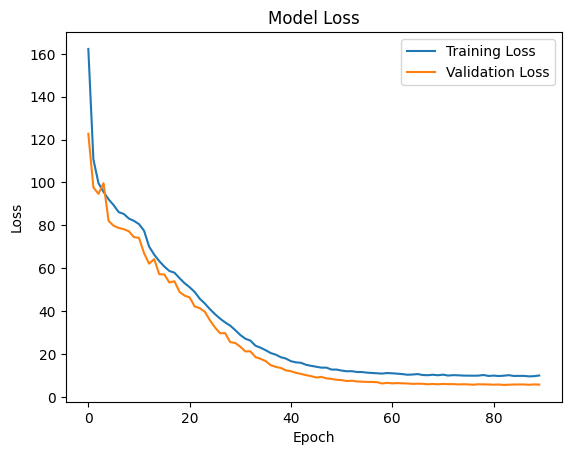

In [26]:
from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()